*Copyright (C) 2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Continually Learning Prototypes (CLP) on real data

**Motivation**: This tutorial aims to demonstrate continual learning of the real data with our CLP algorithm. 

[Interactive continual learning for robots: a neuromorphic approach](https://dl.acm.org/doi/abs/10.1145/3546790.3546791 "Interactive continual learning for robots: a neuromorphic approach")

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with [Process interfaces in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with [ProcessModel implementations in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")
- are familiar with how to [implement a reward-modulated learning rule](../../in_depth/three_factor_learning/tutorial01_Reward_Modulated_STDP.ipynb "Tutorial on R-STDP")
- are familiar with [intorductory tutorial on CLP](../../in_depth/clp/tutorial01_one-shot_learning_with_novelty_detection.ipynb "Tutorial on CLP")

Compared to the introductory CLP tutorial, we will use an upgraded version of the algorithm here. specifically, this version is concurrently capable of both unsupervised and supervised learning. We will perform both pure unsupervised learning via novelty-triggered one-shot learning and semi-supervised learning, where we enable the error signal from the user. The CLP will learn on the extracted features of a dataset (COIL-100), and we will compare unsupervised and semi-supervised learning results to offline K-NN performance. 

In [2]:
import numpy as np
import typing as ty
import matplotlib.pylab as plt
from lava.magma.core.learning.constants import GradedSpikeCfg

from lava.utils.weightutils import SignMode

from lava.magma.core.learning.learning_rule import Loihi3FLearningRule

from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.clp.prototype_lif.process import PrototypeLIF
from lava.proc.clp.novelty_detector.process import NoveltyDetector
from lava.proc.clp.nsm.process import Readout, Allocator
from lava.proc.io.source import RingBuffer, PySendModelFixed
from lava.proc.monitor.process import Monitor
from lava.proc.dense.process import Dense, LearningDense
from lava.proc.dense.models import PyLearningDenseModelBitApproximate

## Dasaset: COIL-100 

<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/coil_100.png" style="width:80%"><center>
<center><figcaption align = "center"> Figure 1. COIL-100 dataset. The dataset includes 72 frames for each of the 100 objects rotated on a turntable. </figcaption><center>

## Data preparation and visualization

### Loading pre-extracted features
The following data file includes extracted features from 42 objects out of the original 100 objects from COIL-100 datasets. As the current implementation of the CLP is the beta version with only novelty-triggered one-shot learning and does not include adaptive prototypes, we have chosen relatively easy objects from the original 100 objects. Here, the "easy" objects are those that are not too similar to each other. An in-house trained feature extractor has extracted these features. Specifically, we have trained a ResNet-9 backbone on the COIL-100 dataset with a self-supervised learning paradigm called SimSiam. The exact details and optimization of the feature extractor are beyond the scope of this tutorial. Here we will focus on how to learn from these extracted features with CLP both in an unsupervised and supervised manner. 

In [6]:
# Load COIL-100 data (selected, well-separated 42 objects)
with open('coil100_features_separated_objs.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

# The label==0 is reserved for "no information" on communication channel
y = y + 1  

# Normalize the vectors
X = X / np.expand_dims(np.linalg.norm(X, axis=1), axis=1)
print(X.shape, y.shape)

(3024, 2048) (3024,)


Let's visualize a histogram of the similarities of a single random example to all the other samples. Note that we use dot product similarity in the Lava implementation of the CLP algorithm. Those samples from the same class will have high similarity, while the rest (majority) will have lower similarity. We can see that in the histogram below: each color is one random sample, and only a small number of samples has $>12000$ similarity to one of these three samples. This histogram also helps us roughly know which range of the similarity values (input currents to PrototypeLIF) we should sample with spike times to compete. Namely, we probably need to better sample the range ```[11000, 12000]``` in terms of spike times. If we run the below cell multiple times, we observe that there are clusters with low and high intra-class variability because there are some samples that have significant similarity to the samples of other classes.

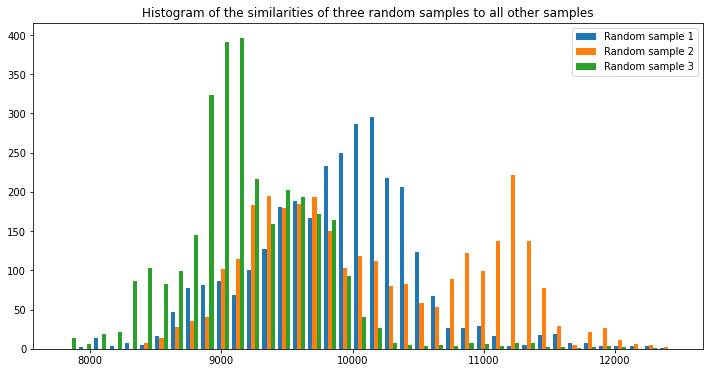

In [7]:
b_fraction = 7  # The fraction of the fixed point representation used to translate floating point input to graded spikes
X_fixed = np.floor(X * 2 ** b_fraction).astype(np.int32)
sim_single = np.dot(X_fixed[np.random.randint(low=0, high=42*72, size=3),:], X_fixed.T)
plt.figure(figsize=(12,6))
plt.hist(sim_single.T, bins=40)
plt.legend(["Random sample 1", "Random sample 2", "Random sample 3"])
plt.title("Histogram of the similarities of three random samples to all other samples")
plt.show()

### Train-test split
There are 72 frames for each object. Let's go ahead and decide how many samples per class we want to provide for training. 

In [39]:
from sklearn.model_selection import train_test_split
n_train_per_class = 3
X_train, X_test, y_train, y_test = train_test_split(X_fixed, y, test_size=(72-n_train_per_class)/72, random_state=42, stratify=y)

### Ordering of the data
Next, we will order the training and testing samples by the objects. This way we simulate online sequential learning. Note that this data order is non-i.i.d, as there is no shuffling.  

In [40]:
X_train = X_train[np.argsort(y_train),:]
y_train = y_train[np.argsort(y_train)]

### Sub-sampling the data
If we wish, we can subsample the test set of each object class by the factor ```k_sample```, as the consecutive image frames are very similar.

In [41]:
k_sample = 3
X_test = X_test[np.argsort(y_test),:][::k_sample, :]
y_test = y_test[np.argsort(y_test)][::k_sample]


Additionally, we can choose how many objects we want to learn out of 42 objects available in the subset of the original dataset that we are providing here in terms of extracted feature vectors. We have chosen 20 objects, but if the simulation takes long time you can decrease it further.

In [42]:
n_classes = 20

X_train = X_train[y_train<=n_classes, :]
X_test = X_test[y_test<=n_classes, :]
y_train = y_train[y_train<=n_classes]
y_test = y_test[y_test<=n_classes]

print(X_train.shape)
print(X_test.shape)

(60, 2048)
(460, 2048)


### Visualization of the similarity between the training and testing samples

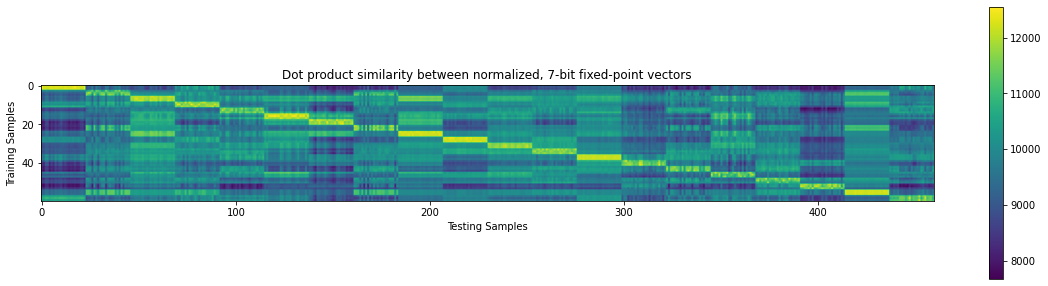

In [43]:
sims = np.dot(X_train, X_test.T)
plt.figure(figsize=(20,5))
plt.imshow(sims)
plt.colorbar()
plt.title("Dot product similarity between normalized, 7-bit fixed-point vectors")
plt.xlabel("Testing Samples")
plt.ylabel("Training Samples")
plt.show()

## Lava diagram of CLP for COIL-100 experiment

<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/clp_coil100_lava_diagram.png" style="width:90%"><center>
<center><figcaption align = "center"> Figure 1. Lava process diagram of the CLP that is capable of both unsupervised and supervised learning </figcaption><center>

Compared to the introductory CLP tutorial, we are using an upgraded version of the algorithm here. Specifically, this version is concurrently capable of both unsupervised and supervised learning. This is possible thanks to error feedback from the ```Readout``` process to the ```Allocator``` process. Basically, when there is a mismatch between the predicted label and the user-provided true label, the ```Readout``` process generates an error signal which triggers the allocation of a new prototype neuron for this mistaken pattern. As we will see later, this will improve the performance. This error feedback can be turned on or off, and based on this the CLP performs semi-supervised or unsupervised learning.

## Temporal Winner-take-all 

To facilitate a somewhat precise competition between similar prototypes, we need a temporal winner-take-all mechanism, where the best matching prototype neuron should spike first and inhibit others by sending them a hard-reset signal. This is also shown in the above diagram. However, we need to tune the voltage threshold, current and voltage decay constants of these neurons so that similar prototypes do not spike at the same time step but have at least one time step difference. For this purpose we want some input current ranges to trigger output spikes at different time steps.

#### (Optional) Hyperparameter search for PrototypeLIF

To achieve this, we can do a hyperparameter search on ```du, dv, vth``` so that each input current value from the list of ```[10500, 11000, 11300, 11600, 11900, 12200]``` elicit output spike at a unique time step. As this hyperparameter search takes time, we have commented it out, but one can rerun this search for other input current values. 

In [44]:
# from utils import wta_hyperparam_search
# a_in = np.array([10500, 11000, 11300, 11600, 11900, 12200])
# n_steps = 35
# best_params = wta_hyperparam_search(a_in, n_steps)

#### Visualize voltage dynamics
Let's also visualize the voltage dynamics with the chosen hyperparameters for the input values we wanted to distinguish in the temporal domain
<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/wta_voltage.png" style="width:50%"><center>
<center><figcaption align = "center"> Figure 1. Voltage dynamics for different values of input current </figcaption><center>

## Offline Supervised Baselines: K-NN accuracy

Before going into the CLP experiments, let's find a baseline accuracy. For this purpose, we used k-NN (k=1), the simplest and one of the most well-known prototype-based approaches. Below we report the offline K-NN (k=1) accuracy is 97.6%. Note that this accuracy can be further improved by using more sophisticated algorithms, but as the dataset is relatively simple, the accuracy is already quite high. Another rationale behind using K-NN is that it is a brute-force and simple version of the current CLP algorithm, as K-NN stores all data, while CLP stores only those that are novel or have triggered a prediction error. We also chose ```n=1``` because CLP uses a single winner-take-all mechanism, and using ```n=1``` for K-NN has a similar effect that the prediction is based on the most similar pattern stored in memory.

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9760869565217392


## Setup the CLP network

Now let's set up our CLP network.

### Parameterization of CLP

In [45]:
# General params
n_features = X_train.shape[1]
t_wait = 14  # the waiting window for novelty detection after input injection
n_protos = 80  # number of the prototypes
# The time difference between two consecutive inputs
n_steps_per_sample = 35

# PrototypeLIF neural dynamics parameters
du = 50
dv = 700
vth = 52000



### Initialize the CLP network
We initialize the CLP object with the global and process-specific parameters. Specifically, ```supervised``` is a flag to signal the system if it should allocate new prototypes based on both the novelty detection and the supervision signal of the user (semi-supervised) or based solely on the novelty detection (unsupervised). ```n_protos``` is the number of the prototypes, ```n_features``` is the length of the input feature vector, ```n_steps_per_sample``` is the number of steps needed to process each input sample, ```b_fraction``` is the number of the bits for fixed representation of the input. In addition, ```du```, ```dv```, ```vth``` are ```PrototypeLIF``` parameters that are taken from the above WTA hyperparameter optimization, while ```t_wait``` is the ```NoveltyDetector``` parameter that specifies the number of time steps to wait for a PrototypeLIF before declaring the input pattern a novel one. 

Using ```generate_input_spikes()``` function we setup input spikes for the whole run: both input pattern spikes and label input spikes. ```setup_procs_and_conns()``` function initialize all the necessary processes of the CLP and connects them.

In [46]:
from clp import CLP

clp = CLP(supervised=False,
          n_protos=n_protos,
          n_features=n_features,
          n_steps_per_sample=n_steps_per_sample,
          b_fraction=b_fraction,
          du=du,
          dv=dv,
          vth=vth,
          t_wait=t_wait)

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train, X_test, y_train)
clp = clp.setup_procs_and_conns(s_pattern_inp, s_user_label)

prototypes = clp.prototypes
num_steps = clp.num_steps

## Unsupervised learning experiment

Here we will perform pure unsupervised learning via novelty-triggered one-shot learning similar to [intorductory tutorial on CLP](../../in_depth/clp/tutorial01_one-shot_learning_with_novelty_detection.ipynb "Tutorial on CLP")

In [47]:
# Run
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds = clp.get_results()

# Stop the run
prototypes.stop()


### Visualization of the results

#### Spike raster plot for the neurons of interest

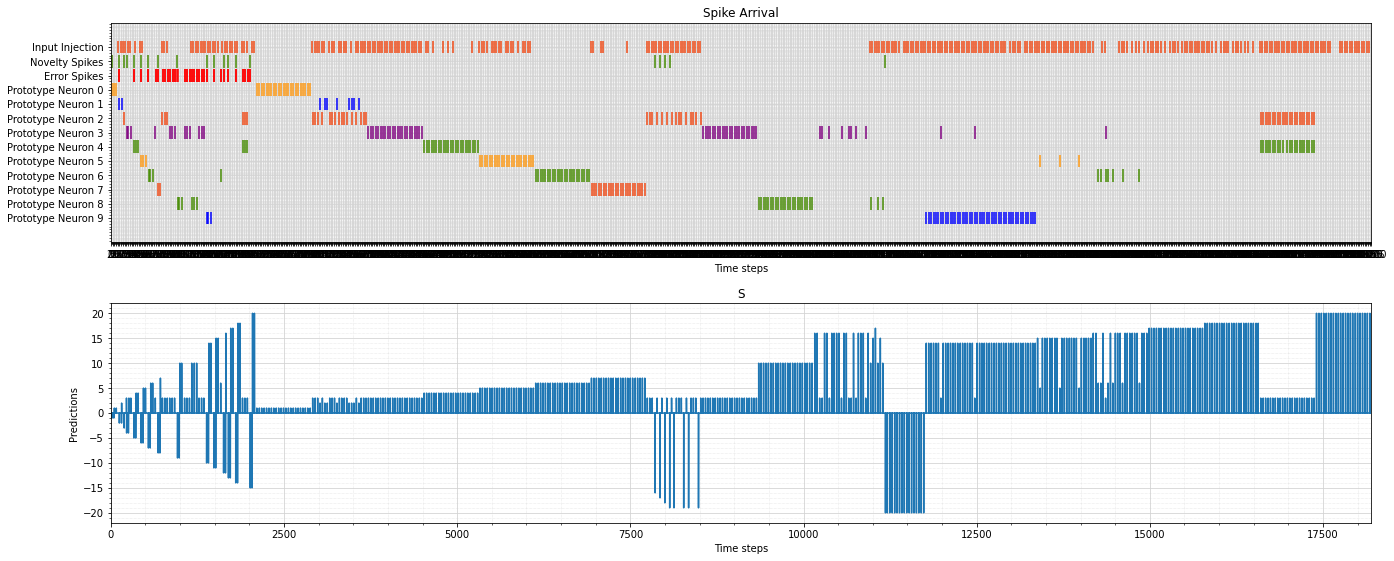

In [48]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 9])[0],
                np.where(proto_spikes[:, 8])[0],
                np.where(proto_spikes[:, 7])[0],
                np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(error_spikes)[0],
                np.where(novelty_spikes)[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        y_label_time_series = 'Predictions',
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 9', 'Prototype Neuron 8',
                'Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 3', 'Prototype Neuron 2',
                'Prototype Neuron 1', 'Prototype Neuron 0', 
                'Error Spikes', 'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#458b00', '#f14a16', '#458b00', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','r','#458b00', '#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

<br/><br/>
<br/><br/>
<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/unsupervised.png" style="width:100%"><center>


#### Extract prediction based on the output of the CLP

In [53]:
n_train_samples = X_train.shape[0]
y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])[n_train_samples:]

#### Confusion matrix for 20 objects

Accuracy:  0.6456521739130435


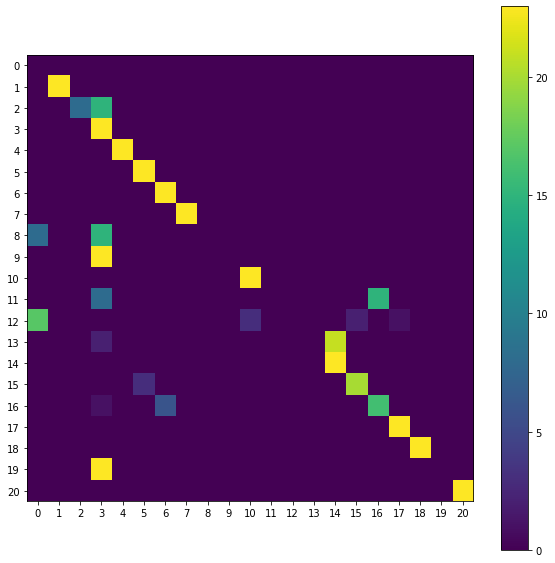

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.xticks(np.arange(n_classes+1))
plt.yticks(np.arange(n_classes+1))
plt.imshow(cm)
plt.colorbar()
plt.show()

## Semi-supervised interactive learning

In the semi-supervised learning experiment, we enable the error signal from the user. As a result, when the predicted label does not match with the true label, an error signal is generated to trigger the allocation of a new prototype.

### Setup CLP with supervision

In [57]:
from clp import CLP

clp = CLP(supervised=True,
          n_protos=n_protos,
          n_features=n_features,
          n_steps_per_sample=n_steps_per_sample,
          b_fraction=b_fraction,
          du=du,
          dv=dv,
          vth=vth,
          t_wait=t_wait)

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train, X_test, y_train)
clp = clp.setup_procs_and_conns(s_pattern_inp, s_user_label)

prototypes = clp.prototypes
num_steps = clp.num_steps

In [58]:
# Run
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds = clp.get_results()

# Stop the run
prototypes.stop()


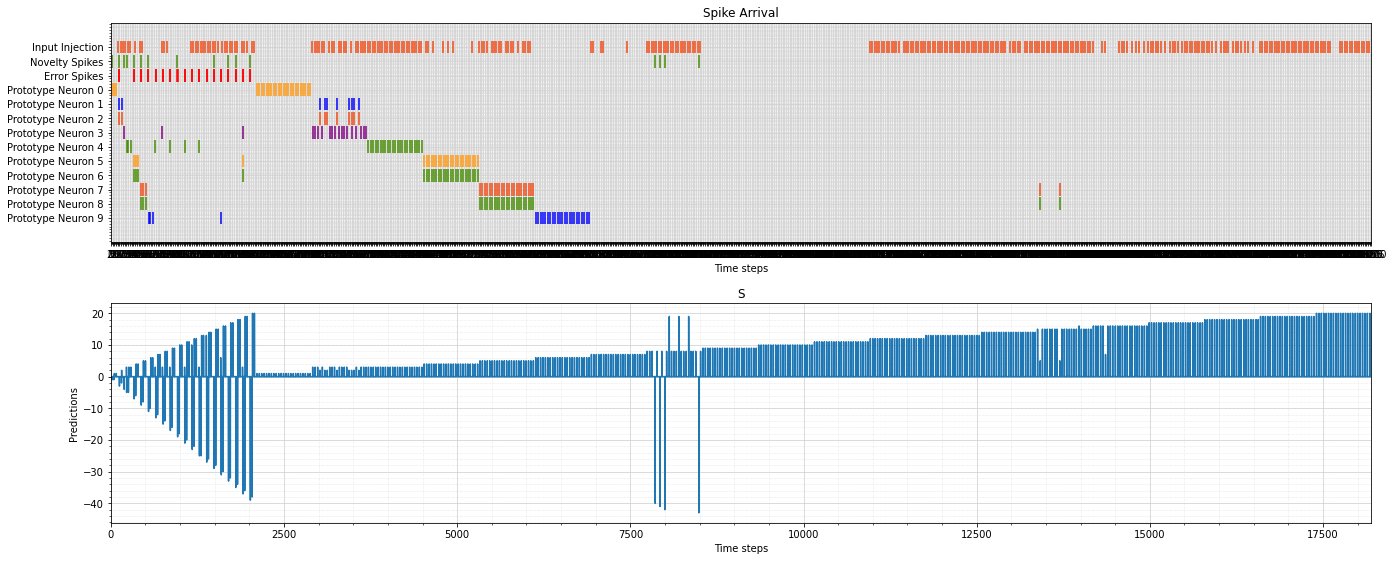

In [62]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 9])[0],
                np.where(proto_spikes[:, 8])[0],
                np.where(proto_spikes[:, 7])[0],
                np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(error_spikes)[0],
                np.where(novelty_spikes)[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        y_label_time_series = 'Predictions',
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 9', 'Prototype Neuron 8',
                'Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 3', 'Prototype Neuron 2',
                'Prototype Neuron 1', 'Prototype Neuron 0', 
                'Error Spikes', 'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#458b00', '#f14a16', '#458b00', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','r','#458b00', '#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

<br/><br/>
<br/><br/>
<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/semi_supervised.png" style="width:100%"><center>

In [59]:
n_train_samples = X_train.shape[0]
y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])[n_train_samples:]

### Performance comparison to the unsupervised and K-NN results

Below we calculate the accuracy of the test set after the semi-supervised learning is finished. As expected, the results are much better than unsupervised learning and very near to offline K-NN results.

Accuracy:  0.9434782608695652


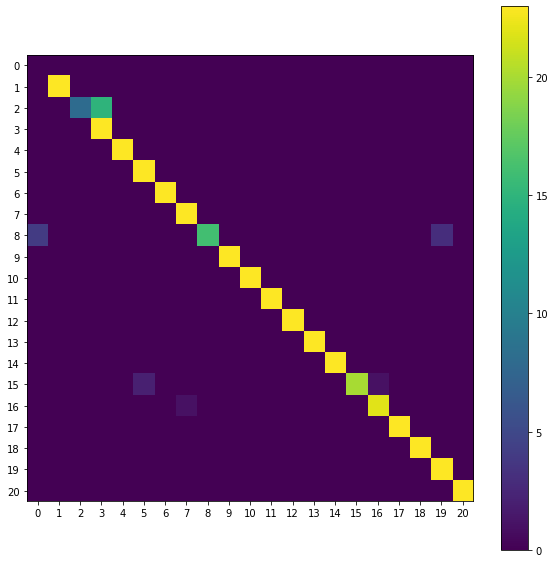

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.xticks(np.arange(n_classes+1))
plt.yticks(np.arange(n_classes+1))
plt.imshow(cm)
plt.colorbar()
plt.show()

## How to learn more?

Learn about details of CLP algorithms and its main processes in the [introductory in-depth tutorial on CLP](./tutorial01_one-shot_learning_with_novelty_detection.ipynb "Introduction to CLP").

If you want to find out more about CLP, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/tree/main/src/lava/proc/clp "Process Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").